<a href="https://colab.research.google.com/github/publicjoey/Simple-use-of-Python-to-implement-NFT-product-analysis-introduction/blob/main/CFD_in_Colab_(2D_car_silhouette).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ecoulement Immeuble_2D_Medium

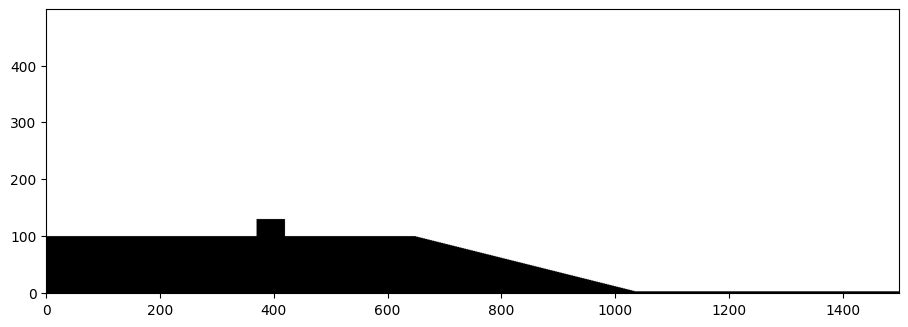

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
# on définit la résolution de calcul
dx=1
dy=1
dt=0.0001
subset=int(1/dx)

# On définit la résolution du dessin
dxd=.1
dyd=.1

rho=1.247 # air 10° en kg/m3
nu=15.6/(10^6) # air en m2/s https://fr.wikipedia.org/wiki/Viscosit%C3%A9_cin%C3%A9matique
g=10 # Constante gravitationnelle sur terre.

# v0=60.0 # (km/h)
v0=200.0 # (km/h)
v0=v0/3.6
p0=101300 # HPa


lx=150
ly=50
# on crée les données
sx=int(lx//dx)
sy=int(ly//dy)

sxd=int(lx//dxd)
syd=int(ly//dyd)


# On crée ensuite la scène
X = np.linspace(0, lx, sx)
Y = np.linspace(0, ly, sy)
S = np.ones((syd, sxd))
def Immeuble(S,x0,y0,L,H,Th,d,dx,dy):
    y0r=float(y0)/dx
    x0r=float(x0)/dx
    Hr=float(H)/dy
    Lr=float(L)/dx
    Thr=float(Th)/dy
    dr=float(d)/dx
    Tw2=(Lr+dr+dr)//2
    S[int(y0r):int(y0r+Hr),int(x0r):int(x0r+Lr)]=0
    for i in range(int(Thr)):
        S[round(y0r+Hr+i),round(x0r-dr+i*Tw2/Thr):round(x0r+Lr+dr-i*Tw2/Thr)]=0
    return S

# On commence par le sol
Ys=10
Xs=65
Xsf=40
# sol
S[:int(Ys/dyd),:]=0
Ts=(Xsf/dxd)/(Ys/dyd)
for i in range(int(Ys/dyd)):
    S[i,round(Xs/dxd+(Ys/dyd-1-i)*Ts):]=1
S[:3,:]=0


# immeuble + garage
# S=Immeuble(S,x0=46,y0=Ys,L=10,H=14,Th=3,d=1,dx=dxd,dy=dyd)
S=Immeuble(S,x0=37,y0=Ys,L=5,H=3,Th=0,d=0,dx=dxd,dy=dyd)

# Maison voisin
# S=Immeuble(S,x0=26,y0=Ys,L=8,H=4,Th=3,d=0,dx=dxd,dy=dyd)
# S=Immeuble(S,x0=10,y0=Ys,L=8,H=6,Th=3,d=0,dx=dxd,dy=dyd)
# S=Immeuble(S,x0=66,y0=Ys-3,L=8,H=4,Th=3,d=0,dx=dxd,dy=dyd)
# S=Immeuble(S,x0=78,y0=Ys-7,L=8,H=4,Th=3,d=0,dx=dxd,dy=dyd)
# S=Immeuble(S,x0=90,y0=Ys-10,L=8,H=4,Th=3,d=0,dx=dxd,dy=dyd)

Sfilter=cv2.resize(S,(sx,sy))
fig = plt.figure(figsize = (11,7), dpi=100)
plt.imshow(S,origin='lower',cmap='gray')
plt.show()


In [4]:
# 檢查 array 資訊
print (type(S))
print(S)
print(S.shape)

<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(499, 1499)


In [5]:
# array 轉 csv
import numpy
numpy.savetxt("foo.csv", S, delimiter=",")

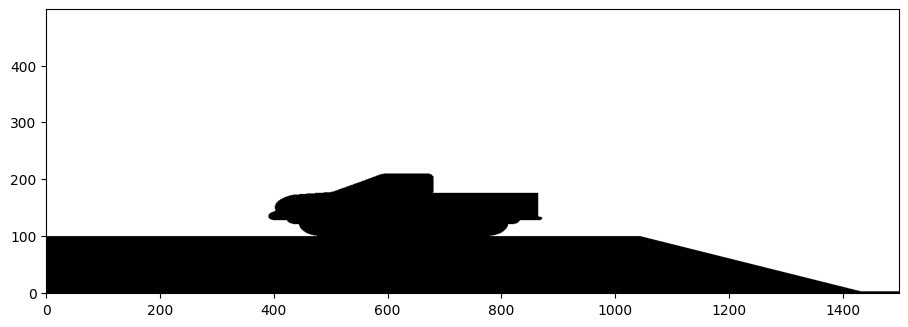

In [8]:
# csv 轉 array
from numpy import genfromtxt
my_data = genfromtxt('Truck2.csv', delimiter=',')
# 更新 汽車外型
S = my_data
# 列印新圖面 檢查
Sfilter=cv2.resize(S,(sx,sy))
fig = plt.figure(figsize = (11,7), dpi=100)
plt.imshow(S,origin='lower',cmap='gray')
plt.show()

On va maintenant reprendre les équations de Navier stokes avec nos conditions initiales.La seconde équation est vraie car le fluide est incompressible

$$\frac{\partial \vec v}{\partial t}+(\vec v.\vec{\mathrm{grad}})(\vec v)=-\frac{1}{\rho}\vec{\mathrm{grad}}(p)+\nu\nabla^2 \vec v+\rho.\vec g$$
$$\nabla.\vec v = 0$$

On peut noter :
$$
\vec H_{v}=\nabla^2\vec v=\left(\frac{\partial^2 \vec v}{\partial x^2}+\frac{\partial^2 \vec v}{\partial y^2}\right)
$$

En projetant, on obtient :
$$\frac{\partial v_{x}}{\partial t}=-v_{x}\frac{\partial v_{x}}{\partial x}-v_{y}\frac{\partial v_{x}}{\partial y}-\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu.H_{v|x}$$

$$\frac{\partial v_{y}}{\partial t}=-v_{x}\frac{\partial v_{y}}{\partial x}-v_{y}\frac{\partial v_{y}}{\partial y}-\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu.H_{v|y}-\rho.g$$

On peut ensuite discrétiser en temps et en espace:
$$
v_{x|i,j}^{n+1}=v_{x|i,j}^{n}+{\Delta T}[\nu(\frac{v_{x|i+1,j}^n-2v_{x|i,j}^n+v_{x|i-1,j}^n}{\Delta x^2}+\frac{v_{x|i,j+1}^n-2v_{x|i,j}^n+v_{x|i,j-1}^n}{\Delta y^2})-v_{x|i,j}^n\frac{v_{x|i+1,j}^n-v_{x|i-1,j}^n}{2\Delta x}-v_{y|i,j}^n\frac{v_{x|i,j+1}^n-v_{x|i,j-1}^n}{2\Delta y}-\frac{1}{\rho}\frac{p_{i+1,j}^n-p_{i-1,j}^n}{2\Delta x}]
$$
$$
v_{y|i,j}^{n+1}=v_{y|i,j}^{n}+{\Delta T}[\nu(\frac{v_{y|i+1,j}^n-2v_{y|i,j}^n+v_{y|i-1,j}^n}{\Delta x^2}+\frac{v_{y|i,j+1}^n-2v_{y|i,j}^n+v_{y|i,j-1}^n}{\Delta y^2})-v_{x|i,j}^n\frac{v_{y|i+1,j}^n-v_{y|i-1,j}^n}{2\Delta x}-v_{y|i,j}^n\frac{v_{y|i,j+1}^n-v_{y|i,j-1}^n}{2\Delta y}-\frac{1}{\rho}\frac{p_{i+1,j}^n-p_{i-1,j}^n}{2\Delta y}-\rho.g]
$$

Les conditions initiales sont :


vX=v0, vY=0, p=0 everywhere, Les conditions de bordures sont :

vX=v0, vY=0, p=0 au niveau des batiments.


Le calcul sera :
Calcul de a et b
Calcul de p
Calcul de H
Calcul de vx et vy


以下是 初始直設定 & 求解器 部分

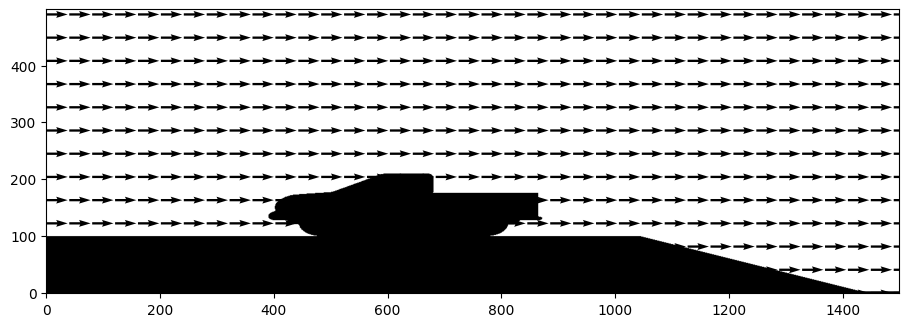

In [9]:
def Subset(*X,s=2,c=0):
    res=[]
    for x in X:
        if len(x.shape)==2:
            t=x[c:-1-c,c:-1-c]
            res.append(t[::s,::s])
        elif len(x.shape)==1:
            t=x[c:-1-c]
            res.append(t[::s])
    if len(res)==1:
        return res[0]
    return tuple(res)

Vx=np.ones((sy,sx))*v0
Vy=np.zeros((sy,sx))
p=np.ones((sy,sx))*p0

fig = plt.figure(figsize = (11,7), dpi=100)
plt.imshow(S,origin='lower',cmap='gray')
Xd,Yd,Vxd,Vyd=Subset(X/dxd,Y/dyd, Vx, Vy,s=4)

plt.quiver(Xd,Yd,Vxd,Vyd,angles='xy')
plt.show()

In [10]:
from IPython.display import clear_output

def Calcul_An_Bn(Vxn,Vyn,dx,dy):
  dVxn_dx=(Vxn[1:-1,2:]-Vxn[1:-1,:-2])/(2*dx)
  dVyn_dy=(Vyn[2:,1:-1]-Vyn[:-2,1:-1])/(2*dy)
  # dérivées croisées
  dVxn_dy=(Vxn[2:,1:-1]-Vxn[:-2,1:-1])/(2*dy)
  dVyn_dx=(Vyn[1:-1,2:]-Vyn[1:-1,:-2])/(2*dx)
  An=dVxn_dx+dVyn_dy
  Bn=dVxn_dx**2+dVyn_dy**2+2*dVxn_dy*dVyn_dx
  return An,Bn

def Calcul_Pression(pn,Vxn,Vyn,dt,dx,dy):
  for i in range(10):
    # on commence par calculer les termes en P
    p0=(
        (
        (dx**2)*(pn[2:,1:-1]+pn[:-2,1:-1])+
        (dy**2)*(pn[1:-1,2:]+pn[1:-1,:-2])
        )
        /
        (2*(dx**2+dy**2))
    )
    facteur=(rho*dx**2*dy**2)/(2*(dx**2+dy**2))
    An,Bn=Calcul_An_Bn(Vxn,Vyn,dx,dy)
    pn[1:-1,1:-1]=facteur*(Bn-An/dt)+p0
    fbord=rho*dy**2/2
    dvy_y0=(Vyn[2:,0]-Vyn[:-2,0])/(2*dy)
    dvy_yf=(Vyn[2:,0]-Vyn[:-2,0])/(2*dy)
    p[1:-1,0]=fbord*(dvy_y0**2-dvy_y0/dt)+(pn[2:,0]+pn[:-2,0])/2
    p[1:-1,-1]=fbord*(dvy_yf**2-dvy_yf/dt)+(pn[2:,-1]+pn[:-2,-1])/2
  return pn

def Laplacien(Vx,Vy,dx,dy):
  Vx_x=(Vx[1:-1,:-2]-2*Vx[1:-1,1:-1]+Vx[1:-1,2:])/(dx**2)
  Vx_y=(Vx[:-2,1:-1]-2*Vx[1:-1,1:-1]+Vx[2:,1:-1])/(dy**2)
  Vy_x=(Vy[1:-1,:-2]-2*Vy[1:-1,1:-1]+Vy[1:-1,2:])/(dx**2)
  Vy_y=(Vy[:-2,1:-1]-2*Vy[1:-1,1:-1]+Vy[2:,1:-1])/(dy**2)
  return Vx_x+Vx_y,Vy_x+Vy_y


def LimitePression(S,pn,dx,dy):
    # Cette fonction permet de forcer un gradient P nul sur les zone avec objet
    Sf=S==0
    Sfg=Sf[1:-1,1:-1]
    for i in range(10):
        gx=(pn[1:-1,1:-1]-pn[1:-1,0:-2])/dx
        gx[Sfg]=0
        gy=(pn[1:-1,1:-1]-pn[0:-2,1:-1])/dy
        gy[Sfg]=0
        #On recompose ensuite à partir du gradient en x et y
        pn[1:-1,1:-1][Sfg]=(gy[Sfg]*dy+pn[0:-2,1:-1][Sfg])/2+(gx[Sfg]*dx+pn[1:-1,0:-2][Sfg])/2
    return pn

def Limite(S,V):
    # Cette fonction permet de forcer à 0 les valeurs où l'objet est absent
    V=np.multiply(S,V)
    return V

udiff = 1
stepcount = 0
while 1:
    VxnI = Vx.copy()
    VynI = Vy.copy()
    pn=p.copy()
    Vxn=VxnI.copy()
    Vyn=VynI.copy()
    Vxn[1:-1,1:-1]=(VxnI[:-2,1:-1]+VxnI[2:,1:-1]+VxnI[1:-1,2:]+VxnI[1:-1,:-2])/4
    Vyn[1:-1,1:-1]=(VynI[:-2,1:-1]+VynI[2:,1:-1]+VynI[1:-1,2:]+VynI[1:-1,:-2])/4
    pn=Calcul_Pression(pn,Vxn,Vyn,dt,dx,dy)
    LapX,LapY=Laplacien(Vxn,Vyn,dx,dy)
    # dérivées
    dVxn_dx=(Vxn[1:-1,2:]-Vxn[1:-1,:-2])/(2*dx)
    dVyn_dy=(Vyn[2:,1:-1]-Vyn[:-2,1:-1])/(2*dy)
    # dérivées croisées
    dVxn_dy=(Vxn[2:,1:-1]-Vxn[:-2,1:-1])/(2*dy)
    dVyn_dx=(Vyn[1:-1,2:]-Vyn[1:-1,:-2])/(2*dx)
    # dérivée pression
    dp_dx=(pn[1:-1,2:]-pn[1:-1,:-2])/(2*dx)
    dp_dy=(pn[2:,1:-1]-pn[:-2,1:-1])/(2*dy)
    # Equation e1 => Vitesse x
    Vx[1:-1, 1:-1] = (Vxn[1:-1, 1:-1]+dt*(
                          nu*LapX+
                          -Vxn[1:-1,1:-1]*dVxn_dx
                          -Vyn[1:-1,1:-1]*dVxn_dy
                          - (1/rho)*dp_dx
                      )
                     )
    Vx[1:-1,-1]=(Vxn[1:-1,-1]+dt*(
        nu*((Vx[:-2,-1]-2*Vx[1:-1,-1]+Vx[2:,-1])/(dy**2)) # On ne garde que le laplacien en X.
        - 0 # la variation en x est nulle
        -Vyn[1:-1,0]*(Vxn[2:,-1]-Vxn[:-2,-1])/(2*dy)
        - (1/rho)*0 # Variation p nulle en 0.
    ))
    # Equation e2 => Vitesse y
    Vy[1:-1, 1:-1] = (Vyn[1:-1, 1:-1]+dt*(
                          nu*LapY+
                          -Vxn[1:-1,1:-1]*dVyn_dx
                          -Vyn[1:-1,1:-1]*dVyn_dy
                          - (1/rho)*dp_dy
                          -rho*g
                      )
                     )
    Vy[1:-1,-1]=(Vyn[1:-1,-1]+dt*(
        nu*((Vy[:-2,-1]-2*Vy[1:-1,-1]+Vy[2:,-1])/(dy**2)) # On ne garde que le laplacien en y.
        - 0 # la variation en x est nulle
        -Vyn[1:-1,0]*(Vyn[2:,-1]-Vyn[:-2,-1])/(2*dy)
        - (1/rho)*(pn[2:,-1]-pn[:-2,-1])/(2*dy)-rho*g # Variation p nulle en 0.
    ))
    p=LimitePression(Sfilter,pn,dx,dy)
    p=Limite(Sfilter,pn)
    Vx=Limite(Sfilter,Vx)
    Vy=Limite(Sfilter,Vy)
    Vx=np.nan_to_num(Vx)
    VxnI=np.nan_to_num(VxnI)
    udiff = abs((np.sum(Vx) - np.sum(VxnI)) / np.sum(Vx))
    clear_output(wait=True)
    print(stepcount)
    print(udiff)
    if udiff<0.0001:
      break
    stepcount += 1


126
9.962646356172228e-05


70.78344425855812


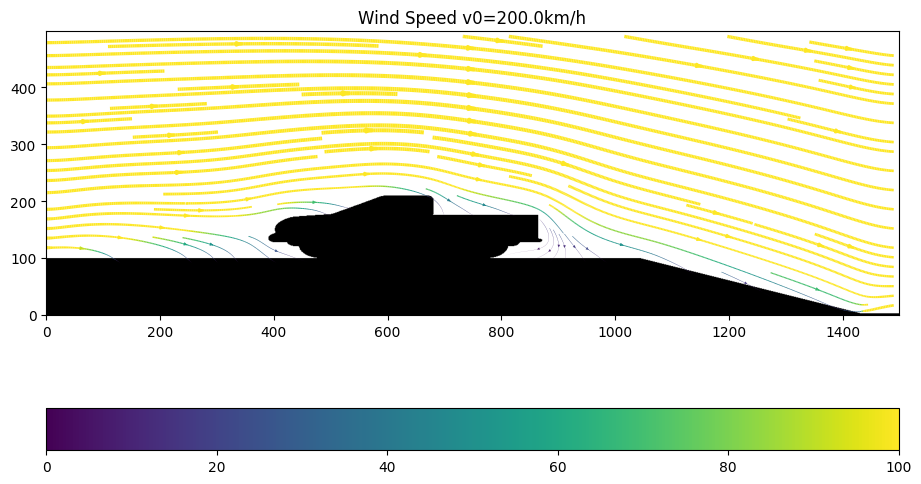

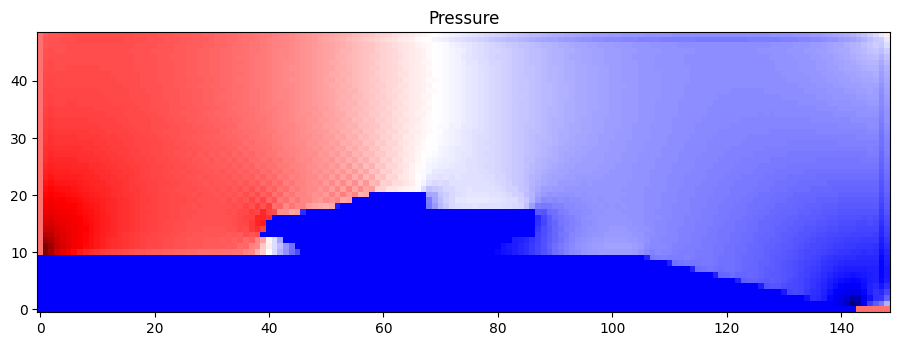

In [11]:
from matplotlib import cm

st=2
stream=True

V=np.sqrt(Vx**2+Vy**2)
norm = matplotlib.colors.Normalize(vmin=0,vmax=100)
sm = matplotlib.cm.ScalarMappable(norm=norm)


fig = plt.figure(figsize = (11,8), dpi=100)
plt.title(f"Wind Speed v0={round(v0*3.6,1)}km/h")
Xd,Yd,Vxd,Vyd,Vd=Subset(X,Y, Vx, Vy, V,s=subset)
print(Vd.max())
if stream:
  col = Vd*3.6
  lw=3*col/col.max()
  stream=plt.streamplot(Xd/dxd, Yd/dyd, Vxd, Vyd,color=col,density=[15,1],linewidth=lw,arrowsize=0.4,norm=norm)
  plt.colorbar(stream.lines,orientation='horizontal')
else:
  plt.quiver(Xd/dxd,Yd/dyd,Vxd,Vyd,Vd,angles='xy',pivot='mid',alpha=0.5,scale=50)
  plt.colorbar(sm,orientation='horizontal')

plt.imshow(S,origin='lower',cmap='gray')
plt.show()

pHPa=p/100
pd=Subset(pHPa,s=1)
pmax=max(abs(pd.max()),abs(pd.min()))
pmean=pd[pd>0].mean()
p_echelle=pmax-pmean
cm='seismic'
norm_p = matplotlib.colors.Normalize(vmin=pmean-p_echelle,vmax=pmax)
sm_p = matplotlib.cm.ScalarMappable(norm=norm_p,cmap=cm)

fig = plt.figure(figsize = (11,8), dpi=100)
plt.title(f"Pressure")
plt.imshow(pd,origin='lower',norm=norm_p,cmap=cm)
plt.show()

